<a href="https://colab.research.google.com/github/Yahred/evolutionary-computation/blob/main/EvolucionAlgorimoConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip freeze > requirements.txt

## Variables

* Número de filtros en las capas ConvLSTM2D:

Para la primera y segunda capa: 16 (puede ser cualquier entero positivo).
Para la tercera capa: también 16 (puede ser cualquier entero positivo).

* Tamaño del kernel en las capas ConvLSTM2D:

Para la primera y segunda capa: (5,5) (puede ser cualquier par de enteros positivos).
Para la tercera capa: (3,3) (puede ser cualquier par de enteros positivos).
* Activación en las capas ConvLSTM2D y Conv2D:

relu para las capas ConvLSTM2D.
sigmoid para la capa Conv2D.
Podrían ser 'tanh', 'softmax', etc.
* Número de canales (channels) en la capa Conv2D:

Depende de tu tarea específica (por ejemplo, 1 para la segmentación binaria, 3 para imágenes RGB).
* Función de pérdida al compilar el modelo:

binary_crossentropy en este ejemplo.
Podrías elegir 'categorical_crossentropy', 'mean_squared_error', etc.
* Optimizador al compilar el modelo:

Adam en este ejemplo.
Podrías elegir 'SGD', 'RMSprop', etc., y también sus hiperparámetros asociados.
* patience para EarlyStopping:

6 en este ejemplo.
Puede ser cualquier entero positivo.
* restore_best_weights para EarlyStopping:

True en este ejemplo.
Puede ser True o False.
* patience para ReduceLROnPlateau:

4 en este ejemplo.
Puede ser cualquier entero positivo.
* Epochs:

20 en este ejemplo.
Puede ser cualquier entero positivo.
* Batch size:

1 en este ejemplo.
Puede ser cualquier entero positivo.

## Librerias y cargar dataset

In [2]:
import os
import cv2
import zipfile
import requests
import zipfile
import io
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Input, Conv2D
from PIL import Image
from google.colab import files
from urllib.request import urlopen
from IPython.display import display, HTML

Se descarga el dataset por medio de una petición HTTP y se extrae


In [3]:
url = 'https://github.com/Yahred/evolutionary-computation/raw/main/data/DroughtDatasetMask.zip'
response = requests.get(url)
data = None

if response.status_code != 200:
  display(HTML((response.text)))
else:
  zip_file = io.BytesIO(response.content)
  data = zipfile.ZipFile(zip_file, 'r')
  data.extractall()

## Funciones

In [4]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

In [5]:
#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

In [6]:
def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img

In [7]:
#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

In [8]:
#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

In [9]:
def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

In [10]:
def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux

In [11]:
def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)

In [12]:
def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

In [13]:
def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new

In [14]:
#Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [15]:
rows = 122
cols = 360
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255]
horizon = 4

De la carpeta con las imagenes pasarlo a un arreglo npy

In [16]:
# Set the path to the folder containing the images
path = "./DroughtDatasetMask"

# Get a list of all the image file names in the folder
image_files = [f for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

# Suponiendo que todas las imágenes tienen el tamaño deseado de 122x360
num_images = len(image_files)  # Asegúrate de que este número corresponde al número de imágenes que deseas cargar

# Verifica que tengas la cantidad correcta de archivos de imagen
if len(image_files) != num_images:
    raise ValueError(f"Expected {num_images} images, but found {len(image_files)}")

# Create an empty numpy array to hold the images
images = np.zeros((num_images, rows, cols), dtype=np.uint8)  # Asegúrate de que el tipo de datos sea correcto

# Loop through the image files and add each image to the numpy array
for i, file in enumerate(sorted(image_files)[:num_images]):  # Asegúrate de que no excedas el número de imágenes deseado
    # Load the image using OpenCV
    img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)  # Directamente en escala de grises
    if img.shape != (rows, cols):
        raise ValueError(f"The image {file} has a shape of {img.shape}, but expected {(rows, cols)}")
    # Add the image to the numpy array
    images[i] = img

# Save the numpy array to a file
numpy_array_path = './DroughtDatasetMask.npy'
np.save(numpy_array_path, images)

"Images shape: {}".format(images.shape)

'Images shape: (1240, 122, 360)'

cargar dataset en formato npy

In [17]:
x = np.load(numpy_array_path)
print (x.shape)

(1240, 122, 360)


In [18]:
x = np.array([gray_quantized(i, np.array(categories)) for i in x])
colors_greys = get_colors(x[1168])
print(f"Colores {colors_greys}")
print(x.shape)

Colores [  0 255 223 190 215 172 176 212 226 224 169 194  78  69  83 168 181 222
 200 217 177 148 165 213 210 184 218 219  76 139 204 113 198 175 156 133
 205 225 216  90  89 162 193 211 117  82 159 154  70  99 174 187 209 214
 110  98 126 170 220 189 173 182 178 197  72  71 221 104 206 208 138 203
 143 188 161 119 127 150 192 166  68  81  62  52  38  36  48  67  66  34
  59  64  57  50  40 180  77 101 201 167 130  60 129 191 195 179  41 202
 199  94 111]
(1240, 122, 360)


In [19]:
# x_greys = np.array([recolor_greys_image(img, categories) for img in x])
# x = x_greys.astype('float32') / 255
# print(get_colors(x[1168]))
# print(x.shape)


url = 'https://github.com/Yahred/evolutionary-computation/raw/main/data/x_greys.zip'
response = requests.get(url)
data = None

if response.status_code != 200:
  display(HTML((response.text)))
else:
  zip_file = io.BytesIO(response.content)
  data = zipfile.ZipFile(zip_file, 'r')
  data.extractall()

x_greys = np.load('./x_greys.npy')
x = x_greys.astype('float32') / 255

Displaying frames for example 494


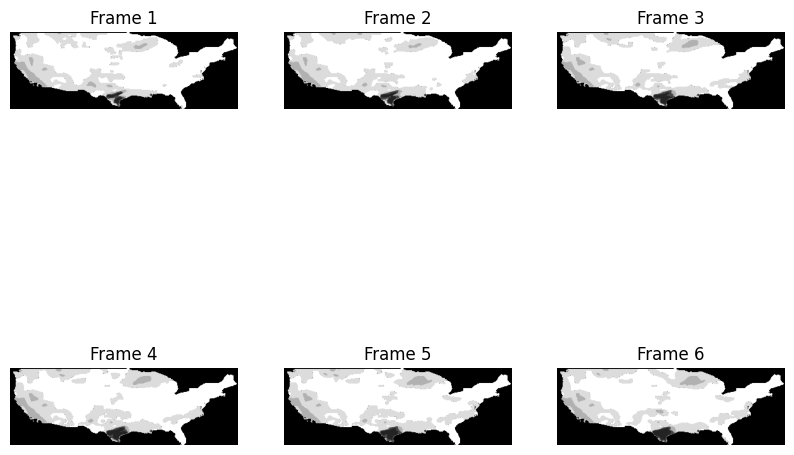

In [20]:
#Mostrar imágenes
fig, axes = plt.subplots(2, 3, figsize= (10,8))

data_choise = np.random.choice(range(len(x)), size= 1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(x[data_choise+idx]), cmap='gray')
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print("Displaying frames for example {}".format(data_choise))
plt.show()

In [21]:
x_2 = agroup_window(x, window)
print(x_2.shape)
x_train = x_2[:int(len(x_2)*.7)]
x_test = x_2[int(len(x_2)*.7):]
x_validation = x_train[int(len(x_train)*.8):]
x_train = x_train[:int(len(x_train)*.8)]

(1236, 5, 122, 360)


In [22]:
x_train = x_train.reshape(len(x_train), window, rows, cols, channels)
x_validation = x_validation.reshape(len(x_validation), window, rows, cols, channels)
x_test = x_test.reshape(len(x_test), window, rows, cols, channels)

print("Forma de datos de entrenamiento: {}".format(x_train.shape))
print("Forma de datos de validación: {}".format(x_validation.shape))
print("Forma de datos de pruebas: {}".format(x_test.shape))

Forma de datos de entrenamiento: (692, 5, 122, 360, 1)
Forma de datos de validación: (173, 5, 122, 360, 1)
Forma de datos de pruebas: (371, 5, 122, 360, 1)


In [23]:
x_train, y_train = create_shifted_frames_2(x_train)
x_validation, y_validation = create_shifted_frames_2(x_validation)
x_test, y_test = create_shifted_frames_2(x_test)

print("Training dataset shapes: {}, {}".format(x_train.shape, y_train.shape))
print("Validation dataset shapes: {}, {}".format(x_validation.shape, y_validation.shape))
print("Test dataset shapes: {}, {}".format(x_test.shape, y_test.shape))

Training dataset shapes: (692, 4, 122, 360, 1), (692, 122, 360, 1)
Validation dataset shapes: (173, 4, 122, 360, 1), (173, 122, 360, 1)
Test dataset shapes: (371, 4, 122, 360, 1), (371, 122, 360, 1)


In [24]:
np.save("/content/x_test_mask.npy", x_test)
np.save("/content/y_test_mask.npy", y_test)

In [ ]:
# #Construction of Convolutional LSTM network
# inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))
# #It will be constructed a 3 ConvLSTM2D layers with batch normalization,
# #Followed by a Conv3D layer for the spatiotemporal outputs.
# m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(inp)
# m = keras.layers.BatchNormalization()(m)
# m = keras.layers.ConvLSTM2D(16, (5,5), padding= "same", return_sequences= True, activation= "relu")(m)
# m = keras.layers.BatchNormalization()(m)
# m = keras.layers.ConvLSTM2D(16, (3,3), padding= "same", activation= "relu")(m)
# m = keras.layers.Conv2D(channels, (3,3), activation= "sigmoid", padding= "same")(m)
# model = keras.models.Model(inp, m)
# model.compile(loss= "binary_crossentropy", optimizer= "Adam")
# print(model.summary())
# #Callbacks
# early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 6, restore_best_weights= True)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 4)
# #Define moifiable training hyperparameters
# epochs = 20
# batch_size = 2
# #Model training
# model.fit(
#     x_train, y_train,
#     batch_size= batch_size,
#     epochs= epochs,
#     validation_data= (x_validation, y_validation),
#     callbacks= [early_stopping, reduce_lr]
# )

In [ ]:
# #Guardar el modelo
# model.save("/content/ConvLSTM2D_Mask122_360.h5")

In [26]:
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

299


In [28]:
example = x_test[imagenInicial]

print(example.shape)

err = model.evaluate(x_test, y_test, batch_size= 2)
print("El error del modelo es: {}".format(err))
preds = model.predict(x_test, batch_size= 2)
print(preds.shape)
x_test_new = add_last(x_test, preds[:])
preds2 = model.predict(x_test_new, batch_size= 2)
#print(preds2.shape)
x_test_new = add_last(x_test_new, preds2[:])
preds3 = model.predict(x_test_new, batch_size= 2)
x_test_new = add_last(x_test_new, preds3[:])
preds4 = model.predict(x_test_new, batch_size= 2)
res_forecast = add_last(x_test_new, preds4[:])
print("PREDSS",res_forecast.shape)

np.save("/content/PredictionsConvolutionLSTM_forecast_122_360_w5.npy", res_forecast)  #Guardar el vector de predicciones

modelos = []
#agregar pred a modelos
modelos.append(preds)
modelos.append(preds2)
modelos.append(preds3)
modelos.append(preds4)


print("Preds" , preds.shape)
print("Preds2" , preds2.shape)
print("Preds3" , preds3.shape)
print("Preds4" , preds4.shape)
print("Res_forecast" , res_forecast.shape)
print("x_test" , x_test.shape)
print("x_test_new" , x_test_new.shape)
print("y_test" , y_test.shape)

# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()



(4, 122, 360, 1)


NameError: ignored

In [29]:

def get_Positions(data, rows= 122, cols=360):
    elements = []
    for i in data:
        ix = int(i/cols)
        iy = int(np.round(((i/cols)-ix)*cols))
        elements.append((ix,iy))
    #print(index/cols)
    #print((index/cols)-ix)
    #print(((index/cols)-ix)*cols)
    print("Posiciones!!! {} , {}".format(ix, iy))
    return elements


#Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

In [30]:

classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
rows = 122
cols = 360
h = 4

data = np.load("/content/PredictionsConvolutionLSTM_forecast_122_360_w5.npy")
x_test = np.load("/content/x_test_mask.npy")
y_test = np.load("/content/y_test_mask.npy")

print(data.shape)
print(x_test.shape)
print(y_test.shape)

y_test = get_cubes(y_test, h)

colors = get_colors(x_test[-10,0])
print("COLORSS", colors)
print("COLORS", colors.shape)

colorss = get_colors(data[-10,0])
print("COLORSS", colorss)

naive = x_test[:-4]
data = data[1:-3]

#y_real = y_test[:, -h:]*255
new_data = data[:, -h:]
n_real = naive[:, -h:]*255

#y_test = y_test[:, -h:]
naive = naive[:, -h:]

print("XX")
print(y_test.shape)
print(new_data.shape)
print(n_real.shape)

print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

new_data = new_data * 255
new_data = new_data.astype(np.uint8)

print("HEY", new_data.shape)
print(colorss.shape)
print(min(new_data[0,0,60]))
print(max(new_data[0,0,60]))

new_data = new_data.reshape(new_data.shape[:-1])
print("HoY", new_data.shape)

aux = []
for i in new_data:
    aux2 = []
    for j in i:
        #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
        #res = recolor_greys_image(j, classes)
        #rgb_quantized(res, classes_rgb)
        #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        res = gray_quantized(j, classes)
        res = recolor_greys_image(res, classes)
        aux2.append(res)
    aux.append(np.array(aux2))
new_data = np.array(aux)
print("SHAPEE", new_data.shape)
color_data = get_colors(new_data[-10,0])
print("DCOLORS", color_data)
new_data = new_data.reshape(new_data.shape[0],new_data.shape[1],new_data.shape[2],new_data.shape[3],1)

#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))*255
#naive = naive.reshape((naive.shape[0], naive.shape[1], naive.shape[2])) * 255

plt.imshow(y_test[0,0], cmap="gray")
#plt.show()


plt.imshow(new_data[0,0], cmap="gray")
#plt.show()


plt.imshow(naive[0,0], cmap="gray")
#plt.show()

y_test = y_test * 255
naive = naive * 255

print("YCOLORS", get_colors(y_test[-10,0]))
print("NCOLORS", get_colors(naive[-10,0]))

print("XS")
print(new_data.shape)
print(y_test.shape)
print(naive.shape)

l_clas = len(classes)

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

#plt.show()

cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
print(cm_f)

for e in range(y_test.shape[0]):
    for k in range(h):
        for i in range(rows):
            for j in range(cols):
                pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                pos2 = np.where(classes == new_data[e, k, i, j])[0][0]
                pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                cm_f[pos1, pos2] += 1
                cm_n[pos1, pos3] += 1

print("Matriz de confusión de pronóstico")
print(cm_f)
print("Matriz de confusión de naive")
print(cm_n)

FileNotFoundError: ignored

NameError: ignored

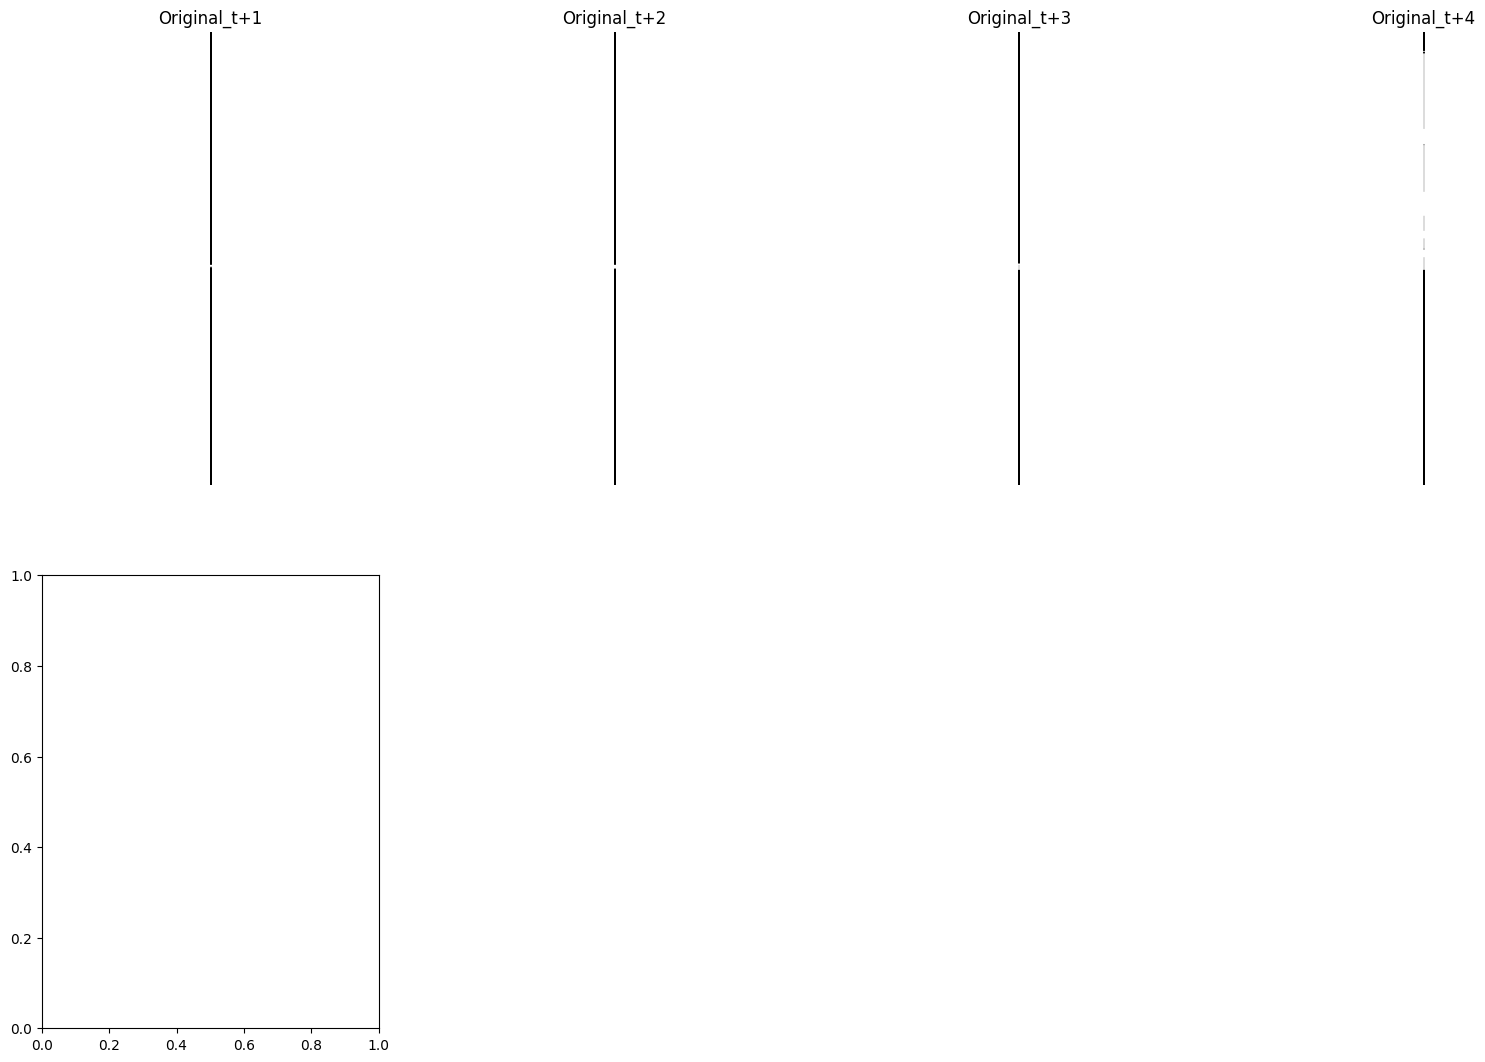

In [31]:
fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

## not working

In [ ]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    for j in range(len(modelos)):
        # Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
        axes[i].imshow(modelos[j][i].squeeze(), cmap='gray')
        axes[i].set_title(f"Predicted Image {i+1}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
n_images = 5  # Define cuántas imágenes quieres mostrar
fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
for i in range(n_images):
    #Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
    print(f"Shape of predicted: {preds[i].shape}")
    axes[i].imshow(preds[i].squeeze(), cmap='gray')
    print(f"Shape of predicted image: {preds[i].shape}")
    axes[i].set_title(f"Predicted Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

In [ ]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(predictions[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()

In [ ]:

example = x_test[imagenInicial]
#frames = example[:4, ...]
#original_frames = example[4:, ...]
print(example.shape)
#print(frames.shape)
#print(original_frames.shape)
for _ in range(horizon):
    print(example.shape)
    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
    example = np.concatenate((example[1:], new_prediction), axis=0)
    print(f"example {example.shape}")
predictions = example[:-3]
print(predictions.shape)
# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()

for i in range(horizon):
    plt.imshow(example[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} Predicted Image")
    plt.axis('off')
    plt.show()

In [ ]:
x_test = x_test[imagenInicial]
for i in range(horizon):
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"{i+1} Predicted Image")
    plt.axis('off')
    plt.show()

# Optimización mediante GAc

Se define el algoritmo genético compacto

In [41]:
import random

class Individual:
    def __init__(self, chrom: list[int]) -> None:
        self.chrom = chrom
        self.fitness = None

    def __str__(self) -> str:
        return '{} Fitness: {}'.format(self.chrom, self.fitness)


def initialize_probs(num_genes: int) -> list[float]:
    return [0.5 for _ in range(num_genes)]


def create_individual(probs: list[float]):
    chrom = ['1' if random.uniform(0, 1) < prob else '0' for prob in probs]
    return Individual(''.join(chrom))


def compete(a: Individual, b: Individual, fitness: callable, fitness_min: bool):
    a.fitness = fitness(a.chrom)
    b.fitness = fitness(b.chrom)

    if a.fitness < b.fitness and fitness_min:
        return a, b

    if a.fitness > b.fitness and not fitness_min:
        return a, b

    return b, a


def adjust_probs(probs: list[float], winner: Individual, loser: Individual, poblacion: int):
    new_probs = []

    for i in range(len(probs)):
        loser_gen = loser.chrom[i]
        winner_gen = winner.chrom[i]

        if winner_gen == loser_gen:
            new_probs.append(probs[i])
            continue

        if winner_gen == '0':
            new_probs.append(probs[i] - (1 / poblacion))
            continue

        new_probs.append(probs[i] + (1 / poblacion))
    return new_probs


def has_converged(probs: list[float], convergence_criteria: float):
    for prob in probs:
        diff = 1 - prob
        if diff > convergence_criteria:
            return False
    return True

def update_hof(winner: Individual, hall_of_fame: list[Individual], size: int, fitness_min: bool = False):
  if not hall_of_fame:
    hall_of_fame.append(winner)
    return

  if not fitness_min and hall_of_fame[-1].fitness > winner.fitness and len(hall_of_fame) == size:
    return

  if fitness_min and hall_of_fame[-1].fitness < winner.fitness and len(hall_of_fame) == size:
    return

  insertion_point = 0
  for i in range(len(hall_of_fame) - 1, -1, -1):
    ancestor = hall_of_fame[i]
    if not fitness_min and ancestor.fitness > winner.fitness:
      insertion_point = i + 1
      break

    if fitness_min and ancestor.fitness < winner.fitness:
      insertion_point = i + 1
      break

  if insertion_point == len(hall_of_fame):
    hall_of_fame.append(winner)
    return

  prev = None
  for i in range(insertion_point, size):
    if not prev:
      prev = hall_of_fame[i]
      hall_of_fame[i] = winner
      continue

    if len(hall_of_fame) <= i and len(hall_of_fame) < size:
      hall_of_fame.append(prev)
      break

    aux = hall_of_fame[i]
    hall_of_fame[i] = prev
    prev = aux


def evolve(fitness: callable, num_genes: int, generations: int, poblacion: int = 50, verbose=False, convergence_criteria=0.001, fitness_min=False, hof = 1, probs=[], save_probs=''):
    best = None
    if (probs):
      print(f'Using preloaded probs {probs}')
    probs = probs or initialize_probs(num_genes)

    hall_of_fame: list[Individual] = []

    for gen in range(generations):
        a = create_individual(probs)
        b = create_individual(probs)

        winner, loser = compete(a, b, fitness, fitness_min)

        if verbose:
          print(f'Gen: {gen + 1}, Winner: {winner.fitness}')

        if not best:
            best = winner
        elif winner.fitness > best.fitness and not fitness_min:
            best = winner
        elif winner.fitness < best.fitness and fitness_min:
            best = winner

        if hof > 1:
          update_hof(winner, hall_of_fame, hof, fitness_min)

        probs = adjust_probs(probs, winner, loser, poblacion)

        if save_probs:
          with open(save_probs, 'wb') as archivo:
              pickle.dump(probs, archivo)

        if has_converged(probs, convergence_criteria):
            break

    if hof > 1:
      return best, hall_of_fame

    return best.chrom, best.fitness

Se definen los hiperparámetros a evolucionar:
   

*   batch_size
*   optimizer
*   learning_rate
*   loss



Definimos una clase HiperParametro que nos ayudará a decodificar a los individuos

In [26]:
N_BITS_DECIMAL = 4

class HiperParametro:
    def __init__(self, nombre, n_bits, posibles_opciones, es_decimal = False) -> None:
        self.nombre = nombre
        self.n_bits = n_bits
        self.posibles_opciones = posibles_opciones
        self.es_decimal = es_decimal

    def transformar_decimal(self, bin: str):
        n_bits = N_BITS_DECIMAL
        decimal = '0.'

        es_uno = True
        for _ in range(0, len(bin), n_bits):
            digito = int(bin[: n_bits], 2)
            bin = bin[n_bits :]

            if digito > 9 or digito == 0:
                digito = 0
            else:
                es_uno = False

            decimal += str(digito)

        return float(decimal)

    def transformar_rango(self, seleccion: int):
        inferior, superior = self.posibles_opciones
        if seleccion + inferior > superior:
            return superior
        return seleccion + inferior

    def obtener_seleccion(self, bin: str):
        seleccion = int(bin, 2)

        if self.es_decimal:
            return self.transformar_decimal(bin)

        if isinstance(self.posibles_opciones, list):
            i = seleccion if seleccion < len(self.posibles_opciones) else len(self.posibles_opciones) - 1
            return self.posibles_opciones[i]

        if isinstance(self.posibles_opciones, tuple):
            return self.transformar_rango(seleccion)

        return 0

Definimos dos listas de la clase HiperParametro para el conjunto de hiperparametros que vamos a entrenar

In [27]:
MAX_MODULOS = 6
hiper_parametros_modelo = [
  HiperParametro('loss', 3, ['binary_crossentropy', 'mse', 'mae']),
  HiperParametro('batch_size', 3, (2, 8)),
  HiperParametro('optimizer', 2, ['adam', 'rmsprop', 'sgd']),
  HiperParametro('n_modulos', 3, (1, MAX_MODULOS)),
]

hiper_parametros_arq = [
  HiperParametro('kernel', 1, [(3,3), (5,5)]),
  HiperParametro('filters', 4, (8, 32)),
  HiperParametro('dropout', 12, N_BITS_DECIMAL, True),
  HiperParametro('recurrent_dropout', 12, N_BITS_DECIMAL, True),
]

Definimos una función que nos ayudará a decodificar un individuo

In [28]:
def decodificar_ind(ind: str):
  bin = ind
  ind_decodificado = {}

  for hiper_parametro in hiper_parametros_modelo:
    bin_seleccion = bin[0 : hiper_parametro.n_bits]
    bin = bin[hiper_parametro.n_bits :]

    ind_decodificado[hiper_parametro.nombre] = hiper_parametro.obtener_seleccion(bin_seleccion)

  ind_decodificado['modulos'] = []
  for _ in range(ind_decodificado['n_modulos']):
    modulo = {}
    for hiper_parametro in hiper_parametros_arq:
      bin_seleccion = bin[0 : hiper_parametro.n_bits]
      bin = bin[hiper_parametro.n_bits : ]

      modulo[hiper_parametro.nombre] = hiper_parametro.obtener_seleccion(bin_seleccion)
    ind_decodificado['modulos'].append(modulo)

  return ind_decodificado

Definimos una función para crear la arquitectura de nuestro modelo proviniente de un individuo decodificado

In [29]:
def crear_modelo(decoded_ind):
  arquitectura = [
      Input(shape=(None, *x_train.shape[2:])),
  ]

  for modulo in decoded_ind['modulos']:
    filters = modulo['filters']
    kernel = modulo['kernel']
    dropout = modulo['dropout']
    recurrent_dropout = modulo['recurrent_dropout']

    arquitectura += [
       ConvLSTM2D(modulo['filters'], modulo['kernel'] , padding="same", dropout=dropout,  return_sequences=True, activation="relu"),
       BatchNormalization()
    ]

  arquitectura += [
      ConvLSTM2D(16, (3,3), padding= "same", activation= "relu"),
      Conv2D(channels, (3,3), activation="sigmoid", padding="same")
    ]

  model = keras.models.Sequential(arquitectura)
  model.compile(loss=decoded_ind['loss'], optimizer=decoded_ind['optimizer'])

  print(model.summary())

  return model

Definimos la función que realizará el entrenamiento parcial

In [30]:
def entrenamiento_parcial(modelo: keras.Model, decoded_ind):
  early_stopping = keras.callbacks.EarlyStopping(monitor= "val_loss", patience=6, restore_best_weights= True)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor= "val_loss", patience= 4)
  epochs = 1
  batch_size = decoded_ind['batch_size']

  history = modelo.fit(
    x_train, y_train,
    batch_size= batch_size,
    epochs= epochs,
    validation_data= (x_validation, y_validation),
    callbacks= [early_stopping, reduce_lr],
  )

  validation_loss, = history.history['val_loss']

  return validation_loss

Se define la función de aptitud

In [31]:
def fitness(ind: str):
  decoded_ind = decodificar_ind(ind)
  modelo = crear_modelo(decoded_ind)
  val_loss = entrenamiento_parcial(modelo, decoded_ind)
  return val_loss

Calculamos el tamaño del cromosoma del individuo

In [32]:
LONGITUD_CROMOSOMA = sum([param.n_bits for param in hiper_parametros_modelo])
LONGITUD_CROMOSOMA += sum([param.n_bits for param in hiper_parametros_arq]) * MAX_MODULOS

LONGITUD_CROMOSOMA

185

Se realizan pruebas con un individuo

In [33]:
ind = ''.join([random.choice(['0', '1']) for _ in range(LONGITUD_CROMOSOMA)])
ind

'01111110001100010010101000001001101011000011100101001101001000010000100111110011100000000000100111001101011011001101011100101001010000111111101100110100110001100111100001110000100011000'

In [34]:
decoded = decodificar_ind(ind)
decoded

{'loss': 'mae',
 'batch_size': 8,
 'optimizer': 'sgd',
 'n_modulos': 2,
 'modulos': [{'kernel': (5, 5),
   'filters': 9,
   'dropout': 0.2,
   'recurrent_dropout': 0.9},
  {'kernel': (3, 3),
   'filters': 15,
   'dropout': 0.29,
   'recurrent_dropout': 0.421}]}

In [42]:
generations = 100
poblacion = 50
hof = 3
ruta_salida = 'probs.pkl'

probs = []

try:
  with open(ruta_salida, 'rb') as archivo:
    probs = pickle.load(archivo)
except FileNotFoundError:
  probs = []

f'Probabilidades iniciales: {probs}'

'Probabilidades iniciales: [0.47, 0.47, 0.6000000000000001, 0.5, 0.45999999999999996, 0.47, 0.44999999999999996, 0.45999999999999996, 0.48, 0.5, 0.43999999999999995, 0.52, 0.48, 0.43999999999999995, 0.51, 0.53, 0.47, 0.54, 0.5800000000000001, 0.5, 0.45999999999999996, 0.48, 0.54, 0.51, 0.53, 0.48, 0.5, 0.47, 0.52, 0.54, 0.42999999999999994, 0.48, 0.45999999999999996, 0.55, 0.55, 0.51, 0.5, 0.47, 0.47, 0.42999999999999994, 0.5700000000000001, 0.55, 0.53, 0.44999999999999996, 0.43999999999999995, 0.54, 0.53, 0.54, 0.47, 0.5, 0.6000000000000001, 0.51, 0.51, 0.51, 0.5, 0.45999999999999996, 0.45999999999999996, 0.48, 0.48, 0.49, 0.52, 0.43999999999999995, 0.53, 0.53, 0.55, 0.52, 0.56, 0.47, 0.51, 0.49, 0.52, 0.53, 0.43999999999999995, 0.52, 0.52, 0.45999999999999996, 0.51, 0.43999999999999995, 0.51, 0.52, 0.43999999999999995, 0.47, 0.5900000000000001, 0.45999999999999996, 0.49, 0.49, 0.52, 0.51, 0.52, 0.52, 0.3699999999999999, 0.45999999999999996, 0.52, 0.47, 0.48, 0.51, 0.42999999999999994

Ejecutar evolución

In [ ]:
best, hof = evolve(fitness, LONGITUD_CROMOSOMA, fitness_min=True, verbose=True, hof=hof, generations=generations, poblacion=poblacion, save_probs=ruta_salida, probs=probs)

Using preloaded probs [0.47, 0.47, 0.6000000000000001, 0.5, 0.45999999999999996, 0.47, 0.44999999999999996, 0.45999999999999996, 0.48, 0.5, 0.43999999999999995, 0.52, 0.48, 0.43999999999999995, 0.51, 0.53, 0.47, 0.54, 0.5800000000000001, 0.5, 0.45999999999999996, 0.48, 0.54, 0.51, 0.53, 0.48, 0.5, 0.47, 0.52, 0.54, 0.42999999999999994, 0.48, 0.45999999999999996, 0.55, 0.55, 0.51, 0.5, 0.47, 0.47, 0.42999999999999994, 0.5700000000000001, 0.55, 0.53, 0.44999999999999996, 0.43999999999999995, 0.54, 0.53, 0.54, 0.47, 0.5, 0.6000000000000001, 0.51, 0.51, 0.51, 0.5, 0.45999999999999996, 0.45999999999999996, 0.48, 0.48, 0.49, 0.52, 0.43999999999999995, 0.53, 0.53, 0.55, 0.52, 0.56, 0.47, 0.51, 0.49, 0.52, 0.53, 0.43999999999999995, 0.52, 0.52, 0.45999999999999996, 0.51, 0.43999999999999995, 0.51, 0.52, 0.43999999999999995, 0.47, 0.5900000000000001, 0.45999999999999996, 0.49, 0.49, 0.52, 0.51, 0.52, 0.52, 0.3699999999999999, 0.45999999999999996, 0.52, 0.47, 0.48, 0.51, 0.42999999999999994, 0.4

In [ ]:
hof_decoded = [decodificar_ind(ind.chrom) for ind in hof]

hof_decoded

[{'loss': 'mae',
  'batch_size': 5,
  'optimizer': 'adam',
  'n_modulos': 1,
  'modulos': [{'kernel': (5, 5),
    'filters': 12,
    'dropout': 0.47,
    'recurrent_dropout': 0.809}]},
 {'loss': 'mae',
  'batch_size': 8,
  'optimizer': 'rmsprop',
  'n_modulos': 1,
  'modulos': [{'kernel': (5, 5),
    'filters': 16,
    'dropout': 0.28,
    'recurrent_dropout': 0.602}]},
 {'loss': 'mae',
  'batch_size': 2,
  'optimizer': 'adam',
  'n_modulos': 6,
  'modulos': [{'kernel': (3, 3),
    'filters': 8,
    'dropout': 0.3,
    'recurrent_dropout': 0.41},
   {'kernel': (3, 3),
    'filters': 22,
    'dropout': 0.002,
    'recurrent_dropout': 0.069},
   {'kernel': (5, 5),
    'filters': 19,
    'dropout': 0.527,
    'recurrent_dropout': 0.0},
   {'kernel': (3, 3),
    'filters': 18,
    'dropout': 0.754,
    'recurrent_dropout': 0.052},
   {'kernel': (3, 3),
    'filters': 19,
    'dropout': 0.001,
    'recurrent_dropout': 0.07},
   {'kernel': (3, 3),
    'filters': 9,
    'dropout': 0.905,
    